<a href="https://colab.research.google.com/github/nichakornchaisuwan/Project_Boneage/blob/main/BoneAgePredictor_NOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pytorch-lightning

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double()

In [7]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double()

In [8]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double()

In [9]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4608, 68)
        self.fc2 = nn.Linear(68, 1)

    def forward(self, x):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        # Pooling
        x = x.view(-1, 4608)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [11]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [12]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('boneage-training-dataset_261.csv', 'boneage-training-dataset-261'),
    batch_size=32, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=32, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=32, shuffle=True, **kwargs)

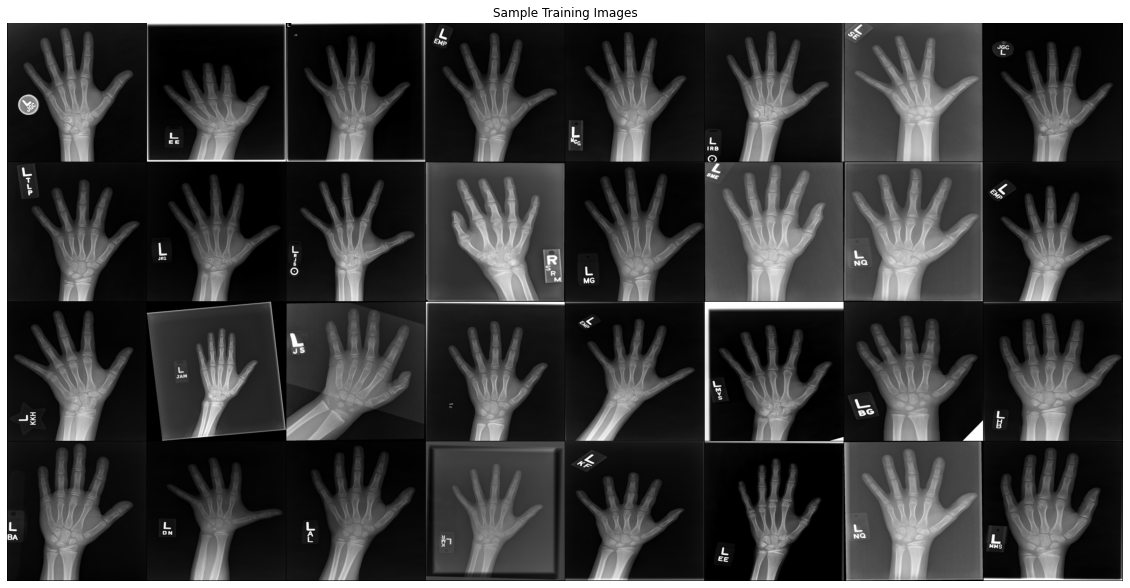

In [14]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(validation_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));
     


In [15]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.001, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=68, bias=True)
  (fc2): Linear(in_features=68, out_features=1, bias=True)
)


In [16]:
train_losses = []
val_losses = []
for epoch in range(3):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_checkpoint.pth')

Train Epoch: 0 [0/261 (0%)]	Loss: 96.020711
Train Epoch: 0 [32/261 (11%)]	Loss: 97.720885
Train Epoch: 0 [64/261 (22%)]	Loss: 85.016930
Train Epoch: 0 [96/261 (33%)]	Loss: 57.944505
Train Epoch: 0 [128/261 (44%)]	Loss: 57.324896
Train Epoch: 0 [160/261 (56%)]	Loss: 50.187407
Train Epoch: 0 [192/261 (67%)]	Loss: 33.509581
Train Epoch: 0 [224/261 (78%)]	Loss: 51.247199
Train Epoch: 0 [40/261 (89%)]	Loss: 42.800987

 Train set: Average loss: 81.8731


 Validation set: Average loss: 98.4229

Train Epoch: 1 [0/261 (0%)]	Loss: 41.234546
Train Epoch: 1 [32/261 (11%)]	Loss: 42.037030
Train Epoch: 1 [64/261 (22%)]	Loss: 41.068650
Train Epoch: 1 [96/261 (33%)]	Loss: 36.496114
Train Epoch: 1 [128/261 (44%)]	Loss: 33.692956
Train Epoch: 1 [160/261 (56%)]	Loss: 44.468574
Train Epoch: 1 [192/261 (67%)]	Loss: 40.403832
Train Epoch: 1 [224/261 (78%)]	Loss: 37.894780
Train Epoch: 1 [40/261 (89%)]	Loss: 47.805102

 Train set: Average loss: 70.7775


 Validation set: Average loss: 83.9301

Train Epoch: 2

In [17]:
checkpoint = torch.load('model_checkpoint.pth')
#checkpoint
     


In [18]:
model.load_state_dict(checkpoint['state_dict'])
#model

<All keys matched successfully>

In [19]:
optimizer.load_state_dict(checkpoint['optimizer'])
#optimizer

In [20]:
epoch = checkpoint['epoch']
#epoch

In [21]:
train_loss = checkpoint['train_loss']
#train_loss

In [22]:
val_loss = checkpoint['val_loss']
#val_loss

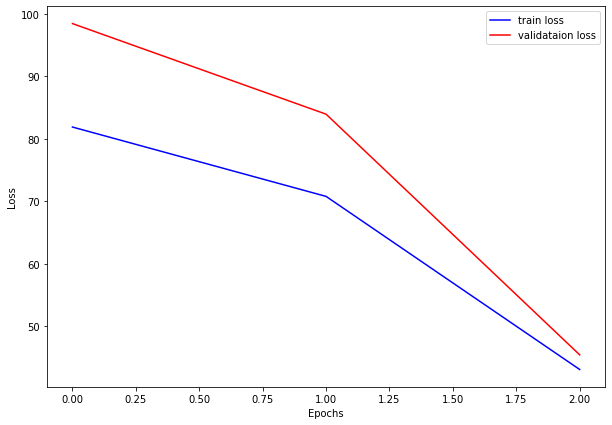

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [25]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)

#Grad cam

In [26]:
import cv2

In [27]:
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = model
model.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model.eval()

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=68, bias=True)
  (fc2): Linear(in_features=68, out_features=1, bias=True)
)

In [28]:
class SaveFeatures:
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output.detach().clone()

    def remove(self):
        self.hook.remove()


In [29]:
class SaveGradients:
    gradients = None

    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach().clone()

    def remove(self):
        self.hook.remove()


In [30]:
layer = model.conv5 # replace with your model's last convolutional layer
activated_features = SaveFeatures(layer)
gradients = SaveGradients(layer)
gradients

In [31]:
input = torch.rand( 1,1, 256, 256)  # replace with your input
input = input.double()
output = model(input)
output.backward()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [32]:
weights = torch.mean(gradients, axis=int)


TypeError: ignored

In [ ]:
heatmap = torch.zeros(activated_features.features.shape[2:])
for i, w in enumerate(weights):
    heatmap += w * activated_features.features[0, i, :, :]

In [ ]:
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(input.squeeze().detach().numpy(), (1, 2, 0)))
plt.imshow(heatmap.detach().numpy(), alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()


#4

In [37]:
import torch
import torch.nn.functional as F
from torchvision import models


class GradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = []
        self.gradient_maps = []

        def save_feature_maps(module, input, output):
            self.feature_maps.append(output.detach())

        def save_gradient_maps(module, grad_input, grad_output):
            self.gradient_maps.append(grad_output[0].detach())

        # Register hooks on the last convolutional layer
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                if 'conv5' in name:
                    module.register_forward_hook(save_feature_maps)
                    module.register_backward_hook(save_gradient_maps)

    def forward(self, x):
        return self.model(x)

    def backward(self, loss):
        self.model.zero_grad()
        loss.backward(retain_graph=True)

    def generate_heatmap(self):
        feature_maps = self.feature_maps[-1]
        gradient_maps = self.gradient_maps[-1]

        # Compute the weights using the gradient maps
        weights = torch.mean(gradient_maps, axis=(2, 3))[0]

        # Compute the weighted feature maps
        weighted_feature_maps = torch.zeros(feature_maps.size()[2:])
        for i, w in enumerate(weights):
            weighted_feature_maps += w * feature_maps[0, i, :, :]

        # Normalize the weighted feature maps
        heatmap = F.relu(weighted_feature_maps)
        heatmap /= torch.max(heatmap)

        return heatmap

# Example usage
model = model
gradcam = GradCAM(model)

# Forward pass
x = torch.randn(1, 1, 256, 256)
x = x.double()
y = gradcam.forward(x)

# Backward pass
loss = torch.sum(y)
gradcam.backward(loss)

# Generate heatmap
heatmap = gradcam.generate_heatmap()


In [38]:
heatmap

tensor([[0.9029, 0.8486, 0.7381, 0.6449, 0.6889, 0.7750, 0.8206, 0.8272, 0.8157,
         0.7761, 0.8485, 0.8104],
        [0.8475, 0.8375, 0.8139, 0.9072, 0.8844, 0.8459, 0.8847, 0.7691, 0.7626,
         0.8228, 0.7454, 0.7613],
        [0.7812, 0.9444, 0.8378, 0.8826, 0.9007, 0.8499, 0.8741, 0.9544, 0.9039,
         0.8528, 0.8101, 0.8064],
        [0.8315, 0.8798, 1.0000, 0.9236, 0.8561, 0.8049, 0.8268, 0.9446, 0.8212,
         0.7946, 0.7901, 0.7765],
        [0.8387, 0.8657, 0.8112, 0.8493, 0.9231, 0.8135, 0.8153, 0.8164, 0.8771,
         0.8983, 0.8878, 0.7820],
        [0.8438, 0.8661, 0.8550, 0.8089, 0.8573, 0.8998, 0.8787, 0.7900, 0.9276,
         0.9612, 0.8318, 0.8462],
        [0.7338, 0.8414, 0.8529, 0.7674, 0.7289, 0.7775, 0.8102, 0.8086, 0.7806,
         0.8051, 0.8378, 0.9077],
        [0.7802, 0.8652, 0.8039, 0.7408, 0.8658, 0.7495, 0.8765, 0.8990, 0.7996,
         0.8308, 0.9316, 0.9258],
        [0.8840, 0.7807, 0.8501, 0.8378, 0.8577, 0.7238, 0.7781, 0.8170, 0.8285,

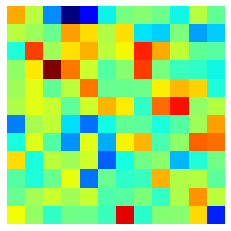

In [100]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(input.squeeze().detach().numpy()))
plt.imshow(heatmap.detach().numpy(), alpha=1, cmap='jet')
plt.axis('off')

plt.show()

TypeError: ignored

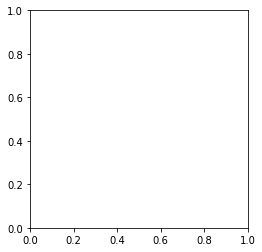

In [98]:
plt.imshow(np.transpose(input))

In [80]:
input.shape

torch.Size([1, 1, 256, 256])

In [85]:
input.squeeze().numpy().transpose().shape

(256, 256)

In [99]:
np.transpose(input.squeeze().detach().numpy(), (256, 256, 1,1)).shape

ValueError: ignored

In [96]:
import matplotlib.pyplot as plt

plt.imshow(input.squeeze().numpy().transpose((256,256,3)), cmap='gray')
plt.imshow(heatmap.squeeze().detach().numpy(), cmap='jet', alpha=1)
plt.show()

ValueError: ignored